In [2]:
! pip install tqdm

     ---------------------------------------- 0.0/77.1 kB ? eta -:--:--
     -------------------- ----------------- 41.0/77.1 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 77.1/77.1 kB 607.8 kB/s eta 0:00:00


In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

# Function to preprocess the images
def preprocess_images(csv_file, img_dir, output_dir):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Loop through each row in the CSV file
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # Get the image file name and label
        img_file = row['id_code']
        label = None
        if 'diagnosis' in row:
            label = row['diagnosis']
        # Load the image and resize
        img_path = os.path.join(img_dir, f"{img_file}.png")
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Failed to load image at path {img_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (512, 512))
        except Exception as e:
            print(f"Error preprocessing image {img_path}: {e}")
            continue

        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        img_l, img_a, img_b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_l = clahe.apply(img_l)
        img_lab = cv2.merge((img_l, img_a, img_b))
        img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

        # Save the preprocessed image to the output directory
        if label:
            output_dir_label = os.path.join(output_dir, str(label))
        else:
            output_dir_label = output_dir
        if not os.path.exists(output_dir_label):
            os.makedirs(output_dir_label)
        img_output_path = os.path.join(output_dir_label, f"{img_file}.png")
        cv2.imwrite(img_output_path, img)

# Preprocess the train images
train_csv_file = 'F:/train.csv'
train_img_dir = 'F:/train_images'
train_output_dir = 'F:/train_preprocessed'
preprocess_images(train_csv_file, train_img_dir, train_output_dir)

# Preprocess the test images
test_csv_file = 'F:/test.csv'
test_img_dir = 'F:/test_images'
test_output_dir = 'F:/test_preprocessed'
preprocess_images(test_csv_file, test_img_dir, test_output_dir)

100%|██████████| 1928/1928 [04:16<00:00,  7.52it/s]


In [2]:
import numpy as np
import pandas as pd
import cv2
from keras.utils import to_categorical
import glob
import os
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Set the paths for the train and test datasets
train_dir = 'F:/train_preprocessed'
test_dir = 'F:/test_preprocessed'
train_csv_file ='F:/train.csv'
test_csv_file = 'F:/test.csv'

In [4]:
# Define the hyperparameters for the model
input_shape = (224, 224, 3)
num_classes = 5
batch_size = 32
num_epochs = 10
lr = 0.001


# Define the Capsule Network model
def CapsuleNetwork(input_shape, num_classes):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    conv1 = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    conv2 = layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(conv1)
    conv3 = layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(conv2)

    # Primary Capsule layer
    primary_caps = layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(conv3)
    primary_caps = layers.Reshape(target_shape=(-1, 8))(primary_caps)

    # Digit Capsule layer
    digit_caps = tf.keras.layers.Dense(units=num_classes*16, activation='relu')(primary_caps)
    digit_caps = tf.keras.layers.Reshape(target_shape=(-1, num_classes, 16))(digit_caps)
    digit_caps = tf.keras.layers.Lambda(lambda x: x / tf.norm(x, axis=-1, keepdims=True))(digit_caps)

    # Output layer
    outputs = layers.Flatten()(digit_caps)
    model = models.Model(inputs=inputs, outputs=outputs)
    
    return model

In [5]:
preprocess_images(train_csv_file, train_img_dir, train_output_dir)
preprocess_images(test_csv_file, test_img_dir, test_output_dir)


100%|██████████| 1928/1928 [02:57<00:00, 10.83it/s]


In [7]:
# Preprocess the train and test images

preprocess_images(train_csv_file, train_img_dir, train_output_dir)
preprocess_images(test_csv_file, test_img_dir, test_output_dir)
# Load the train and test datasets
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=input_shape[:2],
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

# Define the model and compile it
model = CapsuleNetwork(input_shape, num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=lr),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=num_epochs,
                    validation_data=test_generator,
                    validation_steps=len(test_generator))

# Save the trained model
model.save('capsule_network_model.h5')

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)

100%|██████████| 1928/1928 [02:25<00:00, 13.23it/s]


Found 454 images belonging to 4 classes.
Found 0 images belonging to 0 classes.


C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/categorical_crossentropy/mul/BroadcastGradientArgs' defined at (most recent call last):
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Sneha Priya\AppData\Local\Temp\ipykernel_14304\2125624332.py", line 24, in <module>
      history = model.fit(train_generator,
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/categorical_crossentropy/mul/BroadcastGradientArgs'
Incompatible shapes: [32,4] vs. [32,8028160]
	 [[{{node gradient_tape/categorical_crossentropy/mul/BroadcastGradientArgs}}]] [Op:__inference_train_function_2295]

In [8]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf  # import TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical


In [9]:
# Set the paths for the train and test datasets
train_csv_file = 'F:/train.csv'
train_img_dir = 'F:/train_images'
train_output_dir = 'F:/train_preprocessed'
# Preprocess the test images
test_csv_file = 'F:/test.csv'
test_img_dir = 'F:/test_images'
test_output_dir = 'F:/test_preprocessed'

In [10]:
# Function to preprocess the images
def preprocess_images(csv_file, img_dir, output_dir):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Loop through each row in the CSV file
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # Get the image file name and label
        img_file = row['id_code']
        label = None
        if 'diagnosis' in row:
            label = row['diagnosis']
        # Load the image and resize
        img_path = os.path.join(img_dir, f"{img_file}.png")
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Failed to load image at path {img_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (512, 512))
        except Exception as e:
            print(f"Error preprocessing image {img_path}: {e}")
            continue

        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        img_l, img_a, img_b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_l = clahe.apply(img_l)
        img_lab = cv2.merge((img_l, img_a, img_b))
        img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

        # Save the preprocessed image to the output directory
        if label:
            output_dir_label = os.path.join(output_dir, str(label))
        else:
            output_dir_label = output_dir
        if not os.path.exists(output_dir_label):
            os.makedirs(output_dir_label)
        img_output_path = os.path.join(output_dir_label, f"{img_file}.png")
        cv2.imwrite(img_output_path, img)
        

In [11]:
# Preprocess the train and test images
preprocess_images(train_csv_file, train_img_dir, train_output_dir)
preprocess_images(test_csv_file, test_img_dir, test_output_dir)

100%|██████████| 1928/1928 [02:26<00:00, 13.12it/s]


In [12]:
# Define the hyperparameters for the model
input_shape = (224, 224, 3)
num_classes = 5
batch_size = 32
num_epochs = 10
lr = 0.001

In [13]:
# Load the train and test datasets
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_output_dir,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_output_dir,
                                                  target_size=input_shape[:2],
                                                  batch_size=batch_size,
                                                  class_mode='categorical')



Found 454 images belonging to 4 classes.
Found 0 images belonging to 0 classes.


In [14]:
test_filepaths = test_generator.filepaths
print(test_filepaths)


[]


In [15]:
# Check the number of samples in the train and test sets
num_train_samples = len(train_generator.filenames)
num_test_samples = len(test_generator.filenames)
print(f"Number of samples in the train set: {num_train_samples}")
print(f"Number of samples in the test set: {num_test_samples}")

Number of samples in the train set: 454
Number of samples in the test set: 0


In [16]:


# One-hot encode the labels
train_labels = to_categorical(train_generator.classes)
test_labels = to_categorical(test_generator.classes)



ValueError: zero-size array to reduction operation maximum which has no identity

In [17]:
import os

for root, dirs, files in os.walk(test_output_dir):
    for file in files:
        print(os.path.join(root, file))


In [18]:
print(test_generator.directory)

F:/test_preprocessed


In [19]:
# One-hot encode the labels
train_labels = to_categorical(train_generator.classes)
test_labels = to_categorical(test_generator.classes)

ValueError: zero-size array to reduction operation maximum which has no identity

In [20]:
# Define the Capsule Network model
def CapsuleNetwork(input_shape, num_classes):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    conv1 = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    conv2 = layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(conv1)
    conv3 = layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(conv2)

    # Primary Capsule layer
    primary_caps = layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(conv3)
    primary_caps = layers.Reshape(target_shape=(-1, 8))(primary_caps)

    # Digit Capsule layer
    digit_caps = layers.Dense(units=num_classes*16, activation='relu')(primary_caps)
    digit_caps = layers.Reshape(target_shape=(-1, num_classes, 16))(digit_caps)
    digit_caps = layers.Lambda(lambda x: x / tf.norm(x, axis=-1, keepdims=True))(digit_caps)

    # Output layer
    outputs = layers.Flatten()(digit_caps)
    model = models.Model(inputs=inputs, outputs=outputs)
    
    return model

In [21]:
# Define the model and compile it
model = CapsuleNetwork(input_shape, num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

In [22]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=num_epochs,
                    validation_data=test_generator,
                    validation_steps=len(test_generator))

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/categorical_crossentropy/mul/BroadcastGradientArgs' defined at (most recent call last):
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Sneha Priya\AppData\Local\Temp\ipykernel_14304\4062226629.py", line 2, in <module>
      history = model.fit(train_generator,
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\Sneha Priya\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/categorical_crossentropy/mul/BroadcastGradientArgs'
Incompatible shapes: [32,4] vs. [32,8028160]
	 [[{{node gradient_tape/categorical_crossentropy/mul/BroadcastGradientArgs}}]] [Op:__inference_train_function_3442]

In [23]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [24]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [25]:

# Save the trained model
model.save('capsule_network_model.h5')


In [26]:

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)

ValueError: Asked to retrieve element 0, but the Sequence has length 0

IndexError: index 0 is out of bounds for axis 0 with size 0

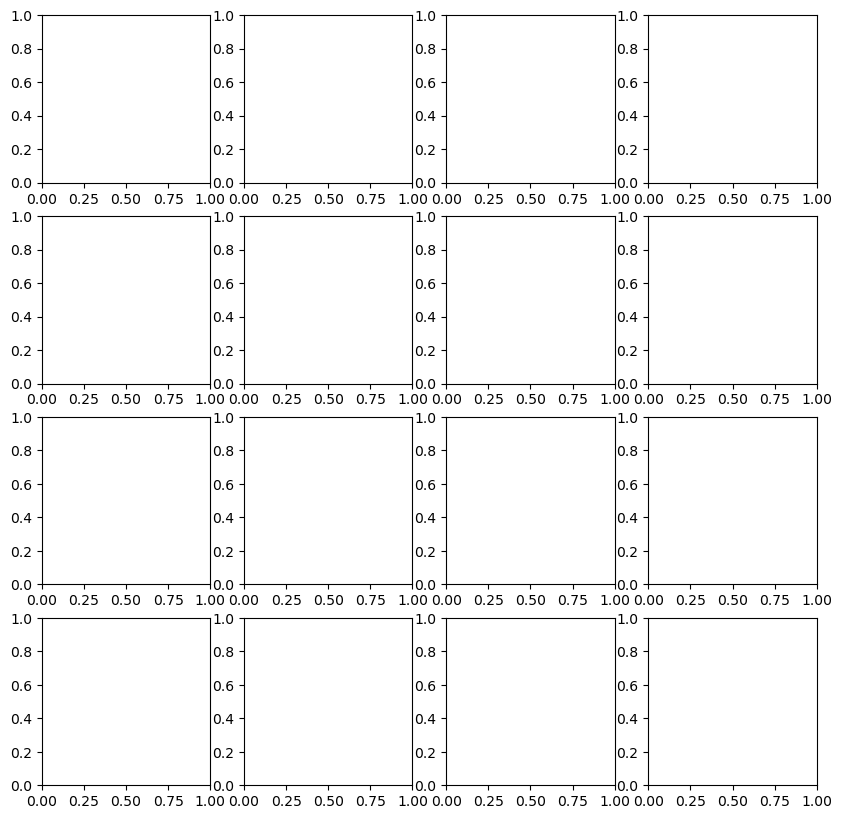

In [27]:
# Get a batch of images from the test generator
images, labels = next(test_generator)

# Plot the images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.ravel()
for i in range(16):
    axs[i].imshow(images[i])
    axs[i].set_title('Label: {}'.format(labels[i]))
    axs[i].axis('off')
plt.show()